**MAP6990 Capstone Project: Telco Customer Churn**

**Author**: Christopher Varney

**Blog Post Link**: [https://cvarney.github.io/telco_customer_churn/](https://cvarney.github.io/telco_customer_churn/)

# Load the necessary packages

In [1]:
# Load packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plotting Packages
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.plotting import scatterplotmatrix

# Sci-kit Learn Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mutual_info_score


# Read the data

In [2]:
# Configure Pandas 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [4]:
# Load Telco Customer Churn file using loaded csv file
df_telco = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Make a copy of the original dataframe
df = df_telco.copy()

# Data Cleaning

## Examine Data Types and Check for Missing Values
First we need to assess our data to see what it looks like and whether there are missing values.

In [5]:
# Examine the data frame
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Examine the shape
df.shape

(7043, 21)

In [7]:
# Look at information about the data frame columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Here we note that the target variable is `Churn` and the `TotalCharges` column has been incorrectly configured as an object data type when it should be a `float64`.

In [8]:
# Define target variable
target = 'Churn'

In [9]:
# Check for null values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Convert Total Charges to a Numeric Data Type

In [10]:
# Convert TotalCharges to numeric data type
# df_telco['TotalCharges'] = df_telco['TotalCharges'].astype('float64') # Raises an exception error
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce') # Force errors to be NaN

In [11]:
# Determine which rows had NaN data for TotalCharges
df[df.isnull().any(axis='columns')]
# Rows 488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754 where the cause of the exception

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [12]:
# Check one of the rows to see what the value was
df_telco.iloc[6670]['TotalCharges']
# Result is a string ' ' instead of a numeric value

' '

In [13]:
# Remove NA values for Total Charges since the Tenure was 0.
df.dropna(inplace=True)

# Recheck for null values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Check number of unique values for each category

In [14]:
# Print categorical column labels & Number of Unique Values
for i in df.columns:
  if df[i].dtype == "object":
    print(i, df[i].nunique(), pd.unique(df[i]), sep=": ")
  # End if
# End for

customerID: 7032: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: 2: ['Female' 'Male']
Partner: 2: ['Yes' 'No']
Dependents: 2: ['No' 'Yes']
PhoneService: 2: ['No' 'Yes']
MultipleLines: 3: ['No phone service' 'No' 'Yes']
InternetService: 3: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: 3: ['No' 'Yes' 'No internet service']
OnlineBackup: 3: ['Yes' 'No' 'No internet service']
DeviceProtection: 3: ['No' 'Yes' 'No internet service']
TechSupport: 3: ['No' 'Yes' 'No internet service']
StreamingTV: 3: ['No' 'Yes' 'No internet service']
StreamingMovies: 3: ['No' 'Yes' 'No internet service']
Contract: 3: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: 2: ['Yes' 'No']
PaymentMethod: 4: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: 2: ['No' 'Yes']


The `customerID` column has a unique value for every entry and should not be kept. The `PaymentMethod` column has extra long strings that should be tidied up.

## Remap binary variables

In [15]:
# Convert Senior Citizen into Yes/No string Data for Data Visualization Purposes Only. Will remap to binary later
col = 'SeniorCitizen'
class_mapping = {1: "Yes", 0: "No"}
df[col] = df[col].map(class_mapping)
print(col, df[col].nunique(), pd.unique(df[col]), sep=": ")

SeniorCitizen: 2: ['No' 'Yes']


## Create total number of services column
The number of services the customer subscribes to could be valuable information. First, need to save a binary Yes/No result for the `InternetService` since there are two Yes types, then can count the services and save in a new column `NumServices`.

In [16]:
# Create a logical variable to keep track of internet service. 
# This is needed or InternetService will not be counted as a service
class_mapping = {"DSL": "Yes", "Fiber optic": "Yes", "No": "No"}
df['InternetServiceStatus'] = df['InternetService'].map(class_mapping)

# Count the number of services the customer has and add to the data frame
ServicesList = ["PhoneService", "InternetServiceStatus", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df['NumServices'] = (df[ServicesList] == "Yes").sum(axis=1)

## Drop unnecessary columns and group columns for Exploratory Data Analysis

In [17]:
# Make lists of the column types
cat_cols = [] #Categorical
num_cols = [] # Numerical
numcat_cols = [] # Numerical (0/1) Category columns
columns_to_drop = []
# categorical columns are only saved if non-numerical & < 15 unique values
# Dropped columns are non-numerical and have >= 15 unique values
for i in df.columns:
  if df[i].nunique() < 15 and df[i].dtype == "object":
    cat_cols.append(i)
  elif df[i].nunique() >= 15 and df[i].dtype == "object":
    columns_to_drop.append(i)
  elif df[i].dtype in ["int64","float64"]:
    if df[i].nunique() == 2:
        numcat_cols.append(i)
    else:
        num_cols.append(i)
    # End if
  # End if
# End for
# Print number of each type of column
print("Category Columns:", cat_cols)
print("Columns to Remove:", columns_to_drop)
print("Numerical Columns:", num_cols)
print("Numerical/Category Columns:", numcat_cols)

Category Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'InternetServiceStatus']
Columns to Remove: ['customerID']
Numerical Columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'NumServices']
Numerical/Category Columns: []


In [18]:
# Drop columns from columns_to_drop list
df = df.drop(columns_to_drop,axis=1)

The data columns can be grouped based on their purpose for Exploratory Data Analysis. The three groupings are:
* Demographic: `gender`, `SeniorCitizen`, `Partner`, `Dependents`
* Account: `tenure`, `Contract`, `PaperlessBilling`, `Payment Method`, `MonthlyCharges`, `TotalCharges`
* Services: `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `NumServices`

In [19]:
# Group columns by category: Demographic, Account, Services
demographic = ['gender', 'SeniorCitizen', "Partner", "Dependents"]
account = ['tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', "TotalCharges"]
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'NumServices']

## Clean Up Object Data

In [20]:
# Tidy up the PaymentMethod values since the strings are too long for the visualizations
df['PaymentMethod'] = df['PaymentMethod'].str.replace(' (automatic)', '', regex = False)

# Exploratory Data Analysis

## Numerical Data

In [21]:
df[num_cols].corr()

,tenure,MonthlyCharges,TotalCharges,NumServices
tenure,1.000000,0.246862,0.825880,0.444244
MonthlyCharges,0.246862,1.000000,0.651065,0.822199
TotalCharges,0.825880,0.651065,1.000000,0.745824
NumServices,0.444244,0.822199,0.745824,1.000000


In [22]:
# Look at properties of columns with numeric (float) values
df.describe()

,tenure,MonthlyCharges,TotalCharges,NumServices
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,3.725256
std,24.545260,30.085974,2266.771362,2.099542
min,1.000000,18.250000,18.800000,1.000000
25%,9.000000,35.587500,401.450000,2.000000
50%,29.000000,70.350000,1397.475000,4.000000
75%,55.000000,89.862500,3794.737500,5.000000
max,72.000000,118.750000,8684.800000,8.000000


In [23]:
# Properties if Churn=Yes
df[df['Churn']=='Yes'].describe()

,tenure,MonthlyCharges,TotalCharges,NumServices
count,1869.000000,1869.000000,1869.000000,1869.000000
mean,17.979133,74.441332,1531.796094,3.616907
std,19.531123,24.666053,1890.822994,1.609944
min,1.000000,18.850000,18.850000,1.000000
25%,2.000000,56.150000,134.500000,2.000000
50%,10.000000,79.650000,703.550000,3.000000
75%,29.000000,94.200000,2331.300000,5.000000
max,72.000000,118.350000,8684.800000,8.000000


In [ ]:
# Properties if Churn=Yes
df[df['Churn']=='No'].describe()

In [24]:
# Create Markdown Tables for Blog Post
# Properties if Churn=Yes/No
df[df['Churn']=='No'].describe().to_markdown()

'|       |    tenure |   MonthlyCharges |   TotalCharges |   NumServices |\n|:------|----------:|-----------------:|---------------:|--------------:|\n| count | 5163      |        5163      |       5163     |    5163       |\n| mean  |   37.65   |          61.3074 |       2555.34  |       3.76448 |\n| std   |   24.0769 |          31.0946 |       2329.46  |       2.24953 |\n| min   |    1      |          18.25   |         18.8   |       1       |\n| 25%   |   15      |          25.1    |        577.825 |       1       |\n| 50%   |   38      |          64.45   |       1683.6   |       4       |\n| 75%   |   61      |          88.475  |       4264.12  |       6       |\n| max   |   72      |         118.75   |       8672.45  |       8       |'

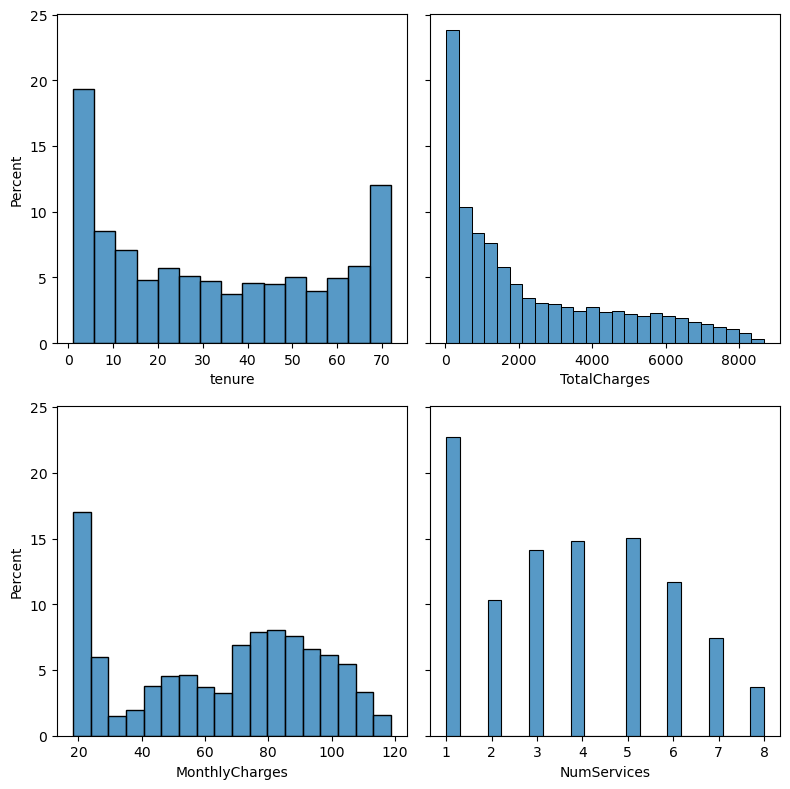

In [25]:
# Multiple plot of numerical values
f, axs = plt.subplots(2,2, figsize=(8,8),sharey=True)
sns.histplot(data=df[num_cols[0]],stat='percent',ax=axs[0,0])
sns.histplot(data=df[num_cols[1]],stat='percent',ax=axs[1,0])
sns.histplot(data=df[num_cols[2]],stat='percent',ax=axs[0,1])
sns.histplot(data=df[num_cols[3]],stat='percent',ax=axs[1,1])
f.tight_layout()
plt.savefig('Numerical.png')
plt.show()

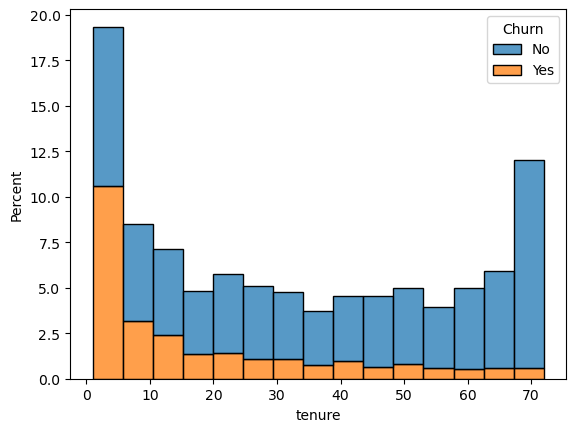

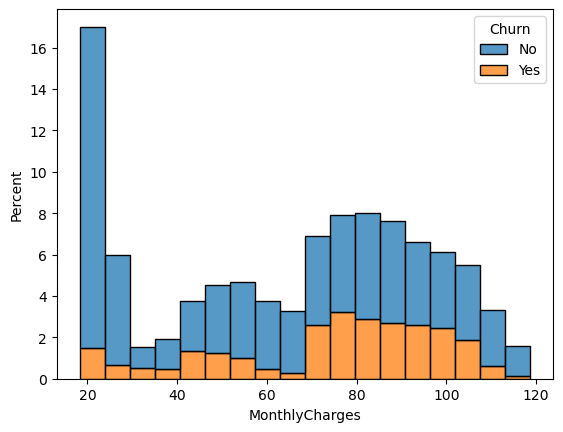

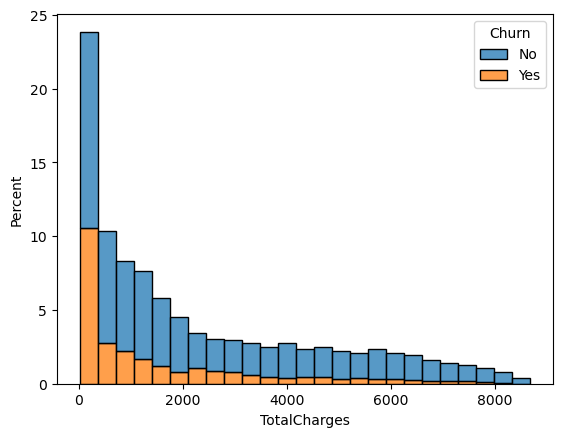

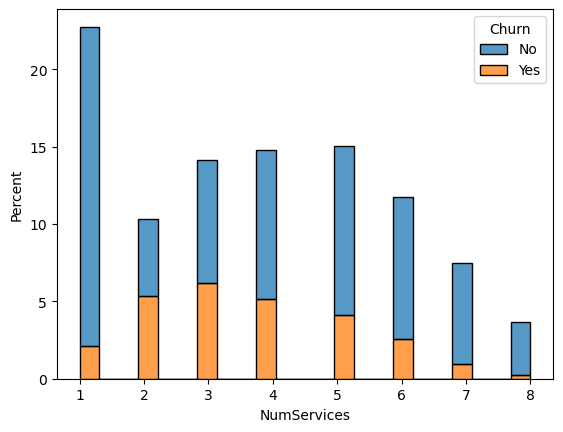

In [26]:
# Plot numerical data columns as a histogram
for col in num_cols:
    sns.histplot(data=df,x=df[col],stat='percent',hue=df['Churn'], multiple='stack')
    plt.show()

## Category ratios

In [27]:
# Print ratios of each category
for col in cat_cols:
    print(df[col].value_counts()/len(df))

Male      0.504693
Female    0.495307
Name: gender, dtype: float64
No     0.8376
Yes    0.1624
Name: SeniorCitizen, dtype: float64
No     0.517491
Yes    0.482509
Name: Partner, dtype: float64
No     0.701507
Yes    0.298493
Name: Dependents, dtype: float64
Yes    0.903299
No     0.096701
Name: PhoneService, dtype: float64
No                  0.481371
Yes                 0.421928
No phone service    0.096701
Name: MultipleLines, dtype: float64
Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: InternetService, dtype: float64
No                     0.497298
Yes                    0.286547
No internet service    0.216155
Name: OnlineSecurity, dtype: float64
No                     0.438993
Yes                    0.344852
No internet service    0.216155
Name: OnlineBackup, dtype: float64
No                     0.439989
Yes                    0.343857
No internet service    0.216155
Name: DeviceProtection, dtype: float64
No                     0.493743
Yes        

## Create Proportion Plot Function

In [29]:
# Determine proportions of Churn for each value of the column
col = services[0]
prop = pd.crosstab(df[col], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)
prop.head()

Churn,No,Yes
PhoneService,,
No,75.000000,25.000000
Yes,73.252519,26.747481


In [37]:
def prop_plot(col,x,y):
    # Calculate the percentage of observations for each variable
    # so that Churn=yes + Churn=No adds up to 100% for each value
    prop = pd.crosstab(df[col], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)
    
    prop.plot(kind='bar',stacked=True, rot=0, ax=axs[x,y])

## Demographic Information

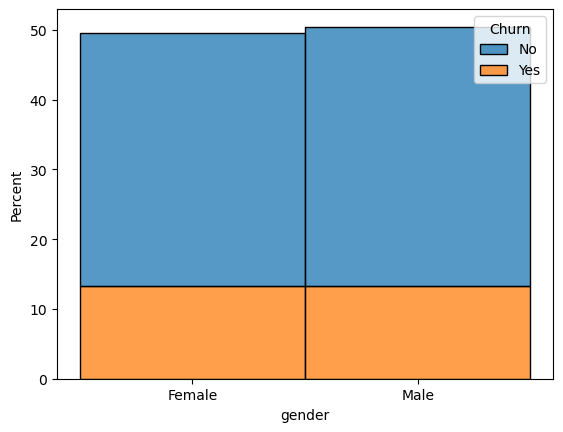

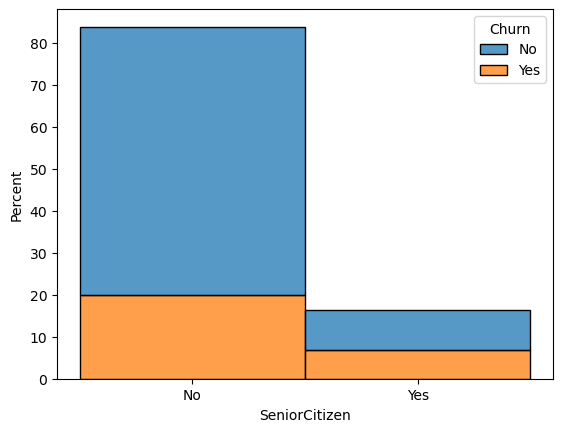

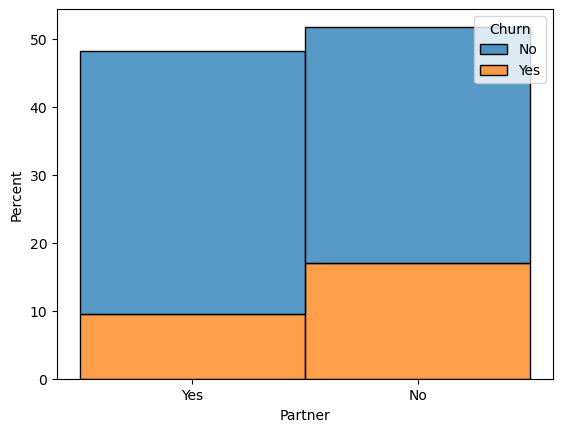

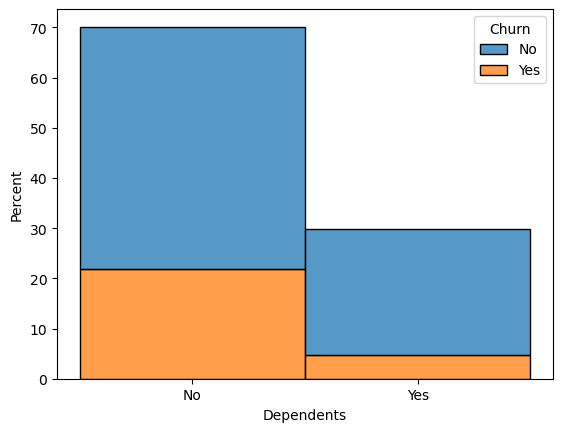

In [28]:
for col in demographic:
    sns.histplot(x=df[col],data=df,stat='percent',hue=df['Churn'],multiple='stack')
    plt.show()

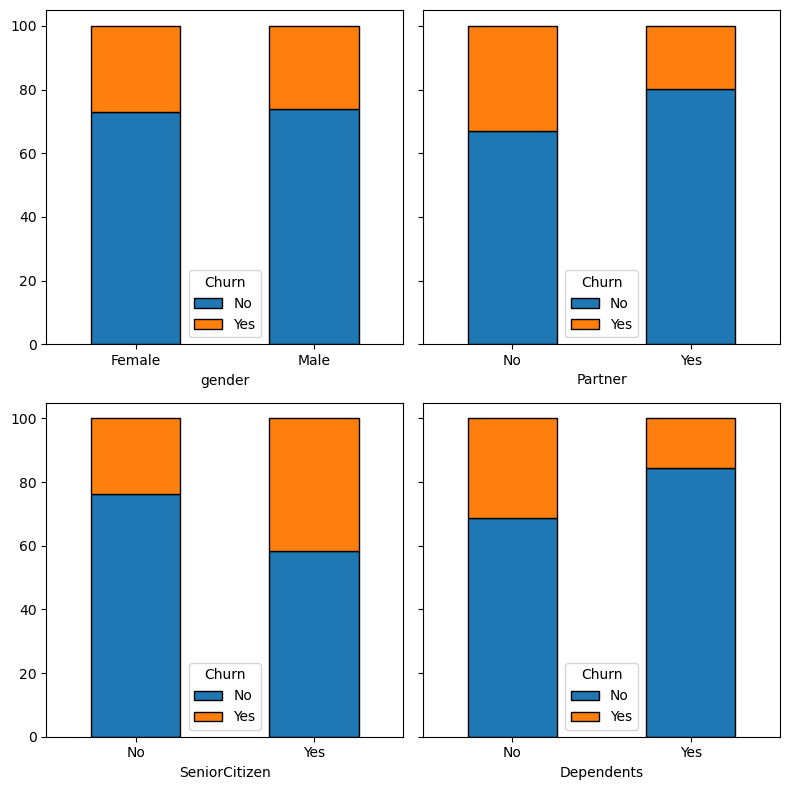

In [34]:
# Multiple proportion plot of demographic values
f, axs = plt.subplots(2,2, figsize=(8,8),sharey=True)
p = 0
for col in demographic:
    x = p % 2
    y = p // 2    
    prop_plot(col,x,y)
    p += 1
f.tight_layout()
#plt.savefig('Demographic.png')
plt.show()

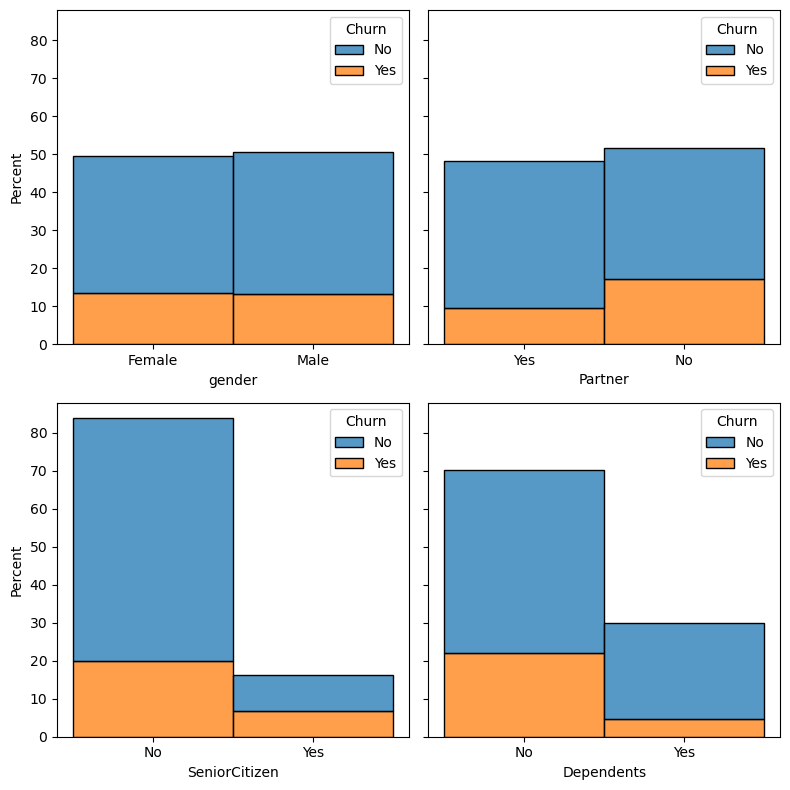

In [31]:
# Multiple percentage plot of demographic values
f, axs = plt.subplots(2,2, figsize=(8,8),sharey=True)
p = 0
for col in demographic:
    x = p % 2
    y = p // 2    
    sns.histplot(data=df,x=df[col],stat='percent',ax=axs[x,y],hue=df['Churn'],multiple='stack')
    p += 1
f.tight_layout()
#plt.savefig('Demographic.png')
plt.show()

## Account Information

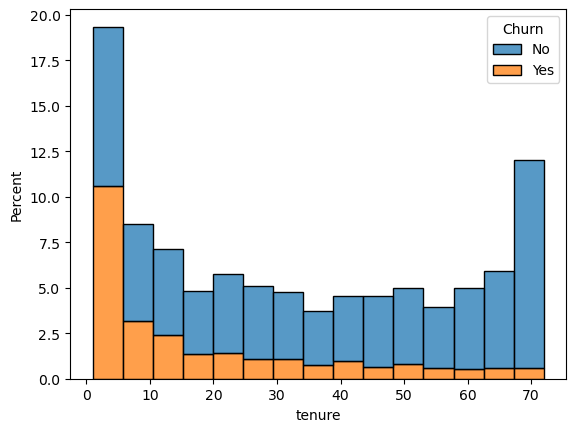

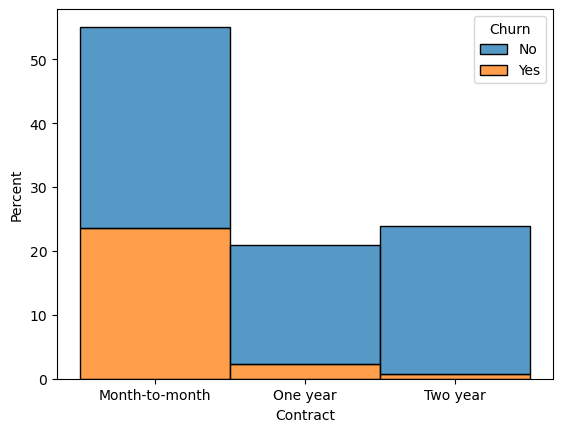

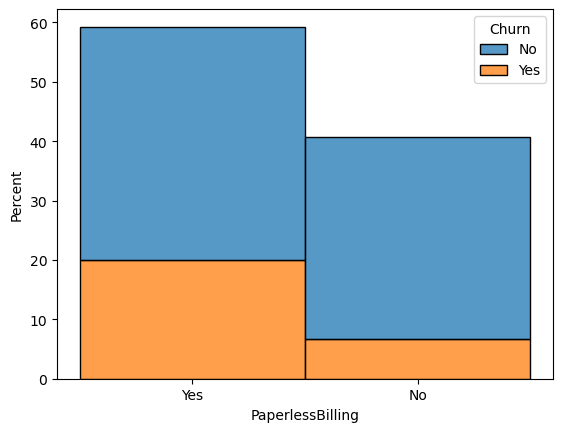

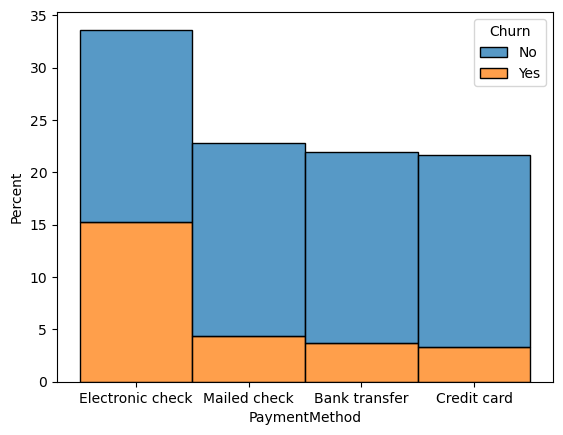

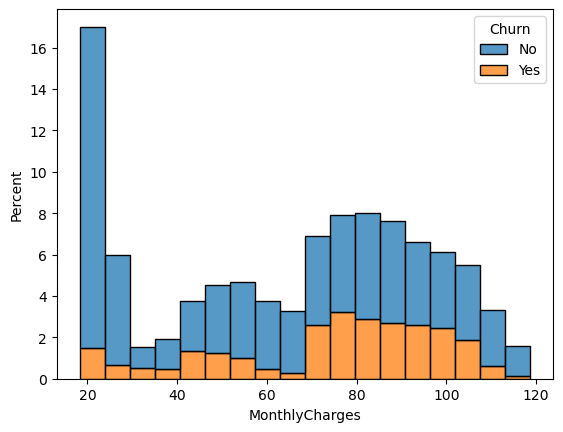

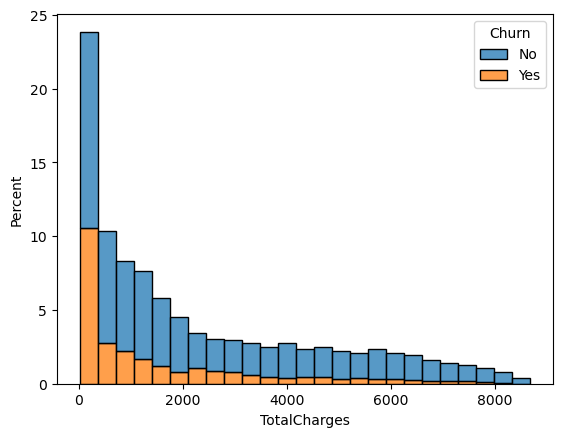

In [35]:
for col in account:
    sns.histplot(x=df[col],data=df,stat='percent',hue=df['Churn'],multiple='stack')
    plt.show()

KeyboardInterrupt: 

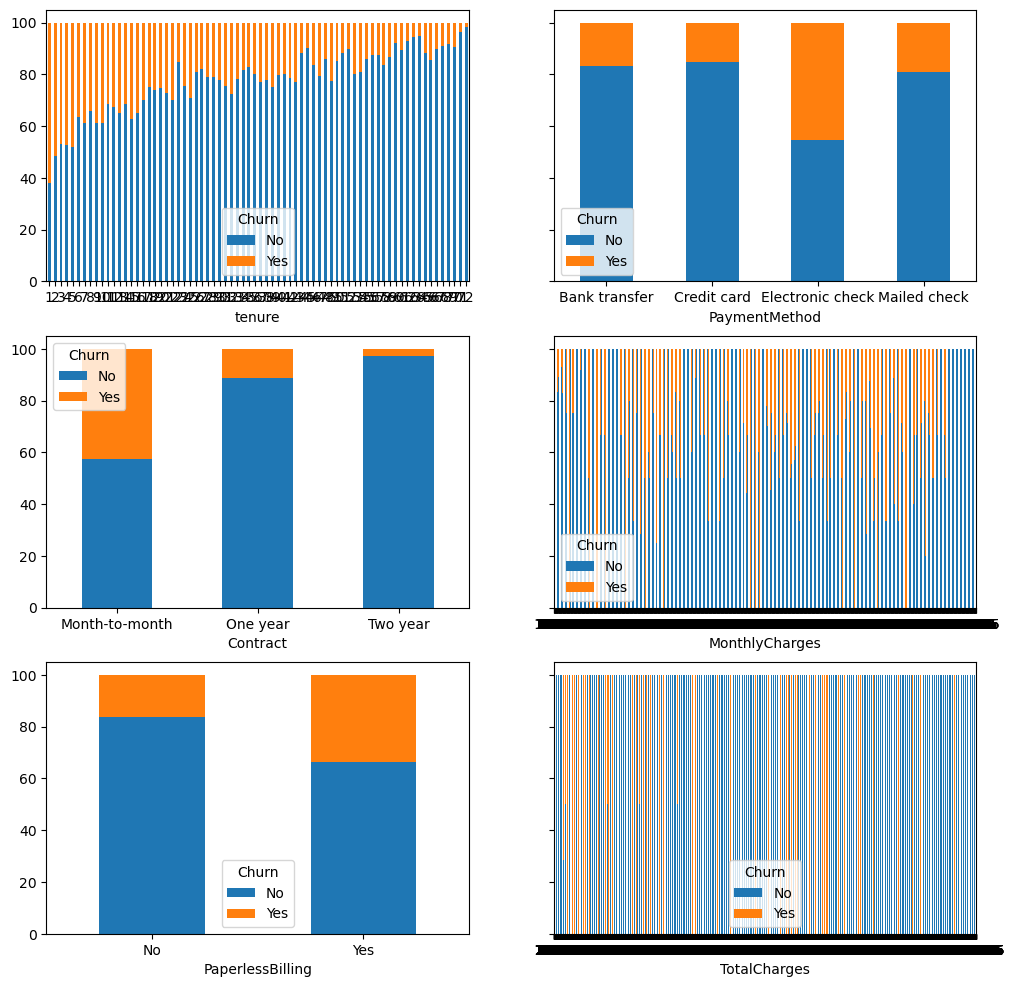

In [38]:
# Multiple proportion plot of account 
f, axs = plt.subplots(3,2, figsize=(12,12),sharey=True)
p = 0;
for col in account:
    x = p % 3
    y = p // 3 
    prop_plot(col,x,y)
    p += 1
f.tight_layout()
#plt.savefig('Account.png')
plt.show()

In [ ]:
# Multiple percentage plot of account 
f, axs = plt.subplots(3,2, figsize=(12,12),sharey=True)
p = 0;
for col in account:
    x = p % 3
    y = p // 3 
    sns.histplot(data=df,x=df[col],stat='percent',ax=axs[x,y],hue=df['Churn'],multiple='stack')
    p += 1
f.tight_layout()
#plt.savefig('Account.png')
plt.show()

## Services Information

In [ ]:
for col in services:
    sns.histplot(x=df[col],data=df,hue=df['Churn'],multiple='stack')
    plt.show()

In [ ]:
# Multiple proportion plot of services
f, axs = plt.subplots(5,2, figsize=(12,16),sharey=True)
p = 0;
for col in services:
    x = p % 5
    y = p // 5 
    prop_plot(col,x,y)
    p += 1
f.tight_layout()
#plt.savefig('Services.png')
plt.show()

In [ ]:
# Multiple percentage plot of services
f, axs = plt.subplots(5,2, figsize=(12,16),sharey=True)
p = 0
for col in services:
    x = p % 5
    y = p // 5 
    sns.histplot(data=df,x=df[col],stat='percent',ax=axs[x,y],hue=df['Churn'],multiple='stack')
    p += 1
f.tight_layout()
#plt.savefig('Services.png')
plt.show()

## Feature Importance

In [ ]:
# Use the mutual info score to get a rudimentary ranking of which category variables are important
mutual_info = {}
for col in cat_cols:
    if col != "Churn":
        mutual_info[col] = (mutual_info_score(df[col],df.Churn))
    # End if
# End for

# Convert dictionary to pandas series and sort
mutual_info = pd.Series(mutual_info).sort_values(ascending=False)
print(mutual_info)

In [ ]:
#plt.figure(figsize=(8,8))
sns.barplot(y=mutual_info.index,x=mutual_info.values)
plt.xlabel("Mutual Info Score")
plt.tight_layout()
#plt.savefig("MutualInfo.png")
plt.show()

# Feature Engineering
Convert all binary columns to 0/1 and use One Hot Encoding to convert all categorical columns with more than 2 values to multiple binary columns.

## Label Encoding

### Binary Data

In [ ]:
# Copy dataframe to preserve the original
dfT = df.copy()

In [ ]:
# Make lists of the column types
bin_cols = [] #Categorical
ohe_cols = [] # Numerical
# categorical columns are only saved if non-numerical & < 15 unique values
# Dropped columns are non-numerical and have >= 15 unique values
for i in df.columns:
  if df[i].nunique() == 2 and df[i].dtype == "object":
    bin_cols.append(i)
  elif df[i].nunique() > 2 and df[i].dtype == "object":
    ohe_cols.append(i)
  # End if
# End for
# Print number of each type of column
print("Binary Columns:", bin_cols)
print("One Hot Encoding Columns:", ohe_cols)

In [ ]:
# Category Label Encoding
for col in bin_cols:
    if col == "gender":
        dfT[col] = dfT[col].map({"Female": 1, "Male": 0})
    else:
        dfT[col] = dfT[col].map({"Yes": 1, "No": 0})

### One Hot Encoding

In [ ]:
dfT = pd.get_dummies(dfT, columns = ohe_cols)
dfT.head()

## Split Train/Test Data
Train and Test Data should be split up before performing data normalization because the test set is unseen data and is not supposed to be available.

In [ ]:
# Split the data into test and training sets with a 80/20 split
Y = dfT.Churn
X = dfT.drop(columns='Churn')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

## Normalization 
Columns with numerical data are `tenure`, `MonthlyCharges`, `TotalCharges` and `NumServices`. Here we are using the `MinMaxScaler` to transform the data to a $[0,1]$ interval.

In [ ]:
mms = MinMaxScaler()
norm_cols = ['tenure','MonthlyCharges','TotalCharges','NumServices']
X_train[norm_cols] = mms.fit_transform(X_train[norm_cols])
X_test[norm_cols] = mms.transform(X_test[norm_cols])

In [ ]:
# Examine the transformed data
X_train.head()

# Model Selection

In [ ]:
models = []

# Hyperparameter Tuning

# Model Performance